<a href="https://colab.research.google.com/github/medha2716/image-seg-ship-detection/blob/main/u_net_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


For semantic segmentation the folder structure needs to look like below
if you want to use ImageDatagenerator.

```
Data/
    train_images/
                train/
                    img1, img2, img3, ......
    
    train_masks/
                train/
                    msk1, msk, msk3, ......
                    
    val_images/
                val/
                    img1, img2, img3, ......                

    val_masks/
                val/
                    msk1, msk, msk3, ......
```
      
   

In [ ]:
!ls '/content/drive/My Drive/u_net_dataset' # it is empty right
DATA_DIR = '/content/drive/My Drive/u_net_dataset/'

train_images  train_masks  val_images  val_masks


# Test and Train images added to respective folders

In [ ]:
import json
import os
import shutil

path_folder_annotations = '/content/drive/My Drive/annotations'

# Load the JSON files with annotations
with open(path_folder_annotations+'/train2017.json', 'r') as f:
    train_data = json.load(f)

with open(path_folder_annotations+'/test2017.json', 'r') as f:
    test_data = json.load(f)

# Directory paths
source_dir = '/content/drive/My Drive/JPEGImages'

# test images
dest_dir = DATA_DIR+'val_images/val'

# Create the destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Loop through each image in the JSON file
for image in test_data['images']:
    file_name = image['file_name']
    source_file = os.path.join(source_dir, file_name)
    dest_file = os.path.join(dest_dir, file_name)

    # Copy the file to the destination directory
    if os.path.exists(source_file):
        if not os.path.exists(dest_file):
          shutil.copy(source_file, dest_file)
        # print(f"Copied {source_file} to {dest_file}")
        else:
          print("File already stored!")
    else:
        print(f"File {source_file} does not exist")

print("Done copying test images!")

# train images
dest_dir = DATA_DIR+'train_images/train'


# Create the destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Loop through each image in the JSON file
for image in train_data['images']:
    file_name = image['file_name']
    source_file = os.path.join(source_dir, file_name)
    dest_file = os.path.join(dest_dir, file_name)

    # Copy the file to the destination directory
    if os.path.exists(source_file):
        if not os.path.exists(dest_file):
          shutil.copy(source_file, dest_file)
        # print(f"Copied {source_file} to {dest_file}")
        else:
          print("File already stored!")
    else:
        print(f"File {source_file} does not exist")

print("Done copying train images!")

Done copying train images!


# Copy test_masks and train_masks

In [ ]:
import shutil
import os

# Define the source and destination paths
source_folder = '/content/drive/My Drive/train_masks'
destination_folder = DATA_DIR+'train_masks/train'


# Move the contents of the source folder to the destination folder
for filename in os.listdir(source_folder):
    shutil.copy(os.path.join(source_folder, filename), os.path.join(destination_folder, filename))

print("Train masks moved successfully!")

# Define the source and destination paths
source_folder = '/content/drive/My Drive/test_masks'
destination_folder = DATA_DIR+'val_masks/val'


# Move the contents of the source folder to the destination folder
for filename in os.listdir(source_folder):
    shutil.copy(os.path.join(source_folder, filename), os.path.join(destination_folder, filename))

print("Val masks moved successfully!")

Train masks moved successfully!
Val masks moved successfully!


# Make dataset

Found 3642 images belonging to 1 classes.
Found 3642 images belonging to 1 classes.
Found 1962 images belonging to 1 classes.
Found 1962 images belonging to 1 classes.


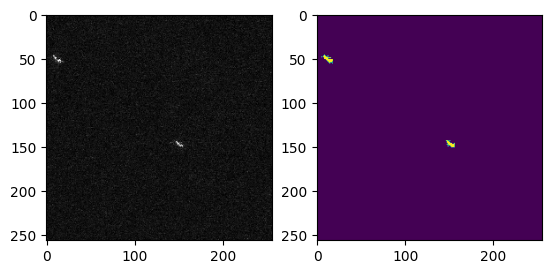

In [ ]:

import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=24
batch_size= 4
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation parameters for images and masks
# can do more augmentations such as flipping some of the images
img_data_gen_args = dict(
    rescale=1/255.,
    fill_mode='reflect'
)

mask_data_gen_args = dict(
    rescale=1/255.,
    fill_mode='reflect',
    preprocessing_function=lambda x: np.where(x > 0, 1, 0).astype(x.dtype)  # Binarize the output
)

# Create ImageDataGenerators for images and masks
image_data_generator = ImageDataGenerator(**img_data_gen_args)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

# Define the directory paths
DATA_DIR = '/content/drive/My Drive/u_net_dataset/'
seed = 42  # Ensure reproducibility
batch_size = 4
target_size = (256, 256)  # Set to the original image size

# Flow images from directory
image_generator = image_data_generator.flow_from_directory(
    DATA_DIR + "train_images/",
    seed=seed,
    batch_size=batch_size,
    class_mode=None,
      # Ensure images are not resized (can add target_size = target_size)
)

# Flow masks from directory
mask_generator = mask_data_generator.flow_from_directory(
    DATA_DIR + "train_masks/",
    seed=seed,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None,
      # Ensure masks are not resized
)

# Validation data generators
valid_img_generator = image_data_generator.flow_from_directory(
    DATA_DIR + "val_images/",
    seed=seed,
    batch_size=batch_size,
    class_mode=None,
    target_size=target_size  # Ensure validation images are not resized
)

valid_mask_generator = mask_data_generator.flow_from_directory(
    DATA_DIR + "val_masks/",
    seed=seed,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None,
    target_size=target_size  # Ensure validation masks are not resized
)

# Zip the image and mask generators
train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)




x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()


# Prepare U-Net Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate


def double_conv_block(x, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(x, num_filters):
    x = double_conv_block(x, num_filters)
    p = MaxPool2D((2, 2))(x)
    # p = layers.Dropout(0.2)(p) # 20 percent dropout rate
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = double_conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = double_conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation = "softmax")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

# Train and Save the model

In [ ]:
#Jaccard distance loss mimics IoU.
from keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam, SGD


#Dice metric can be a great metric to track accuracy of semantic segmentation.
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]


input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

model = build_unet(input_shape)

model.summary()

# # Compile the model
# model.compile(optimizer=Adam(lr = 1e-3), loss="sparse_categorical_crossentropy",
#               metrics=[dice_metric])


# Compile the model with the initial optimizer and additional metrics
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])



# Train the model


num_train_imgs = len(os.listdir(DATA_DIR+'train_images/train/'))

steps_per_epoch = num_train_imgs //batch_size


history = model.fit(train_generator, validation_data=val_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=steps_per_epoch, epochs=5)



model.save('u_net_ship_hrsid_softmax.h5')





(256, 256, 3)
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_norm

# Predict and Visualize

Found 1962 images belonging to 1 classes.
Found 1962 images belonging to 1 classes.


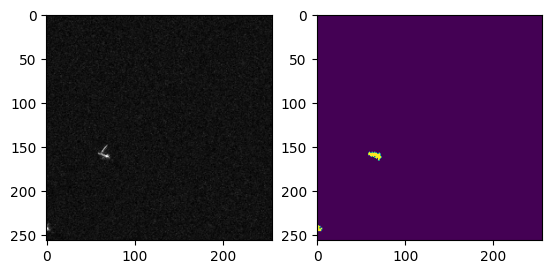

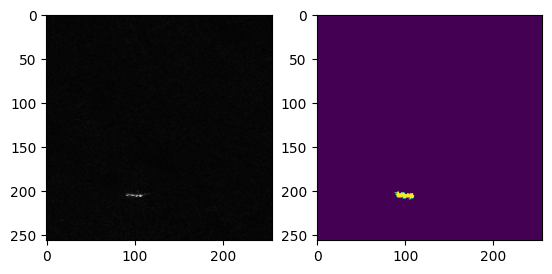

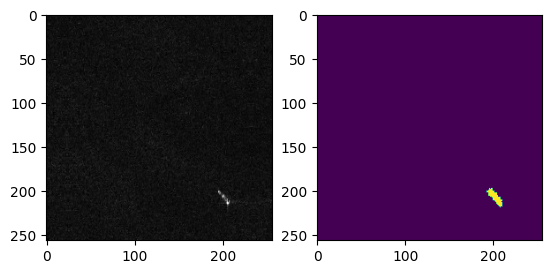

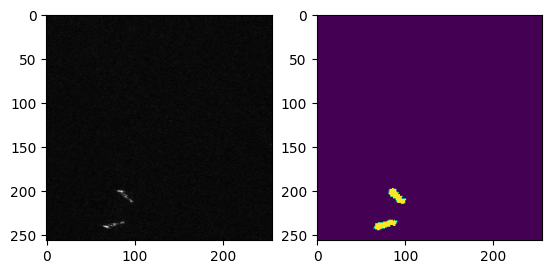

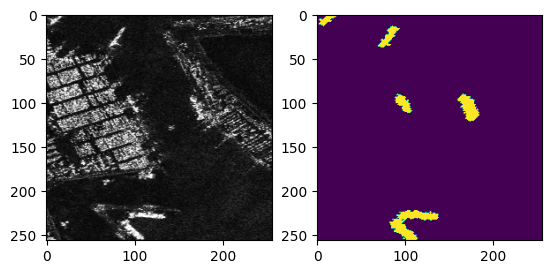

1/1 [==============================] - 1s 585ms/step


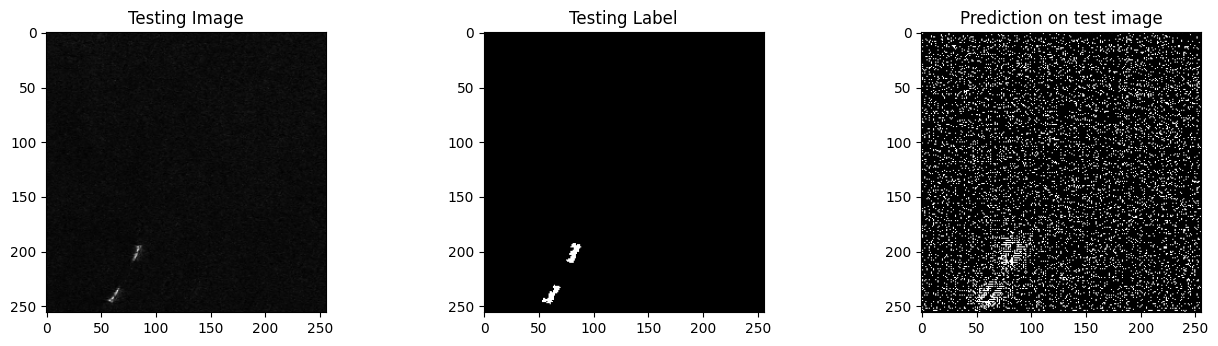

Mean IoU = 0.44100952
1/1 [==============================] - 0s 39ms/step
0.19563293
1/1 [==============================] - 0s 32ms/step
0.18686676
1/1 [==============================] - 0s 33ms/step
0.17108154
1/1 [==============================] - 0s 35ms/step
0.14949799
1/1 [==============================] - 0s 35ms/step
0.22725677
1/1 [==============================] - 0s 29ms/step
0.24828339
1/1 [==============================] - 0s 36ms/step
0.19132996
1/1 [==============================] - 0s 31ms/step
0.16194153
1/1 [==============================] - 0s 28ms/step
0.19087982
1/1 [==============================] - 0s 31ms/step
0.16687012
1/1 [==============================] - 0s 29ms/step
0.1486435
1/1 [==============================] - 0s 29ms/step
0.1694107
1/1 [==============================] - 0s 20ms/step
0.19138336
1/1 [==============================] - 0s 24ms/step
0.17364502
1/1 [==============================] - 0s 34ms/step
0.17554474
1/1 [==============================

In [ ]:
##############################################################
#Test the model on images we held out for testing.
#We can use the generator again for predictions.

model = tf.keras.models.load_model("u_net_ship_hrsid.hdf5", compile=False)
!mv u_net_ship_hrsid.hdf5 "/content/drive/My Drive/" # move the saved model to drive

test_img_generator = image_data_generator.flow_from_directory(DATA_DIR+"val_images/",
                                                              seed=seed,
                                                              batch_size=32,
                                                              class_mode=None)

test_mask_generator = mask_data_generator.flow_from_directory(DATA_DIR+"val_masks/",
                                                              seed=seed,
                                                              batch_size=32,
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)


a = test_img_generator.next()
b = test_mask_generator.next()
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU and average

import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)



df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)



